# Projeto 2

a) e b)

############################################################################ 
 n° reatores:  1 
 volume de cada CSTR:  10.0 m3
C_a1 = 66.66667 mol/L
Elapsed time: 0.00000 seconds


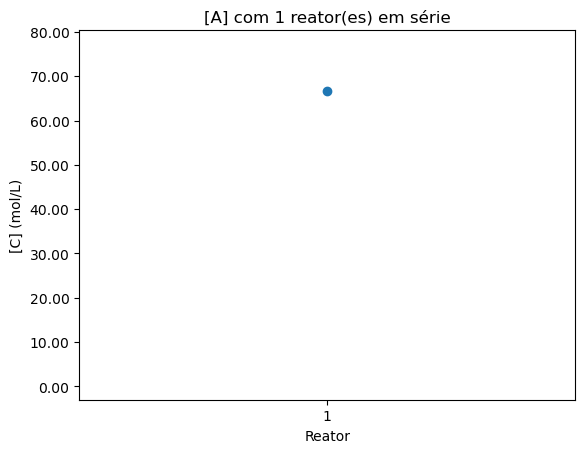

############################################################################ 
 n° reatores:  2 
 volume de cada CSTR:  5.0 m3
C_a1 = 127.27273 mol/L
C_a2 = 11.57025 mol/L
Elapsed time: 0.00100 seconds


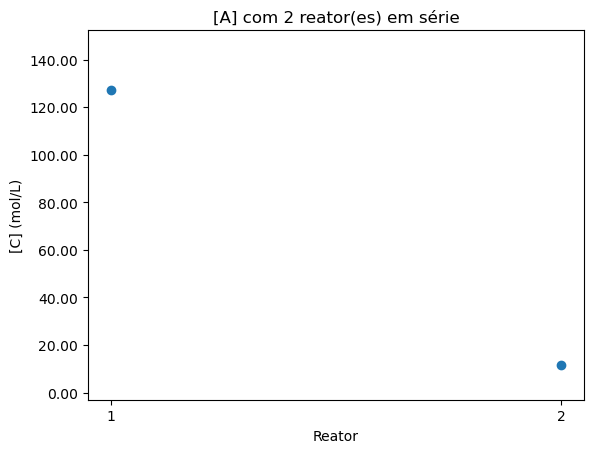

############################################################################ 
 n° reatores:  4 
 volume de cada CSTR:  2.5 m3
C_a1 = 233.33333 mol/L
C_a2 = 38.88889 mol/L
C_a3 = 6.48148 mol/L
C_a4 = 1.08025 mol/L
Elapsed time: 0.00000 seconds


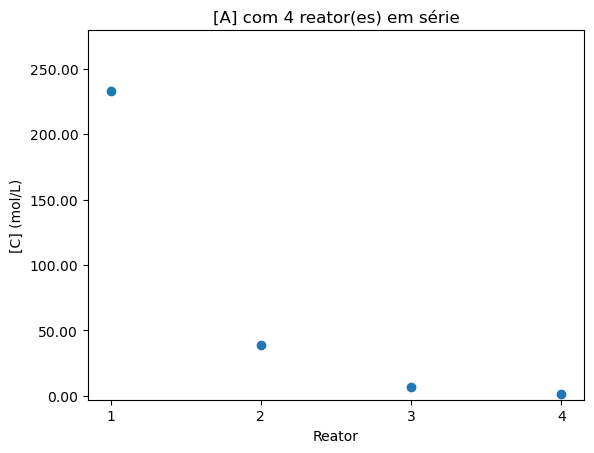

############################################################################ 
 n° reatores:  10 
 volume de cada CSTR:  1.0 m3
C_a1 = 466.66667 mol/L
C_a2 = 155.55556 mol/L
C_a3 = 51.85185 mol/L
C_a4 = 17.28395 mol/L
C_a5 = 5.76132 mol/L
C_a6 = 1.92044 mol/L
C_a7 = 0.64015 mol/L
C_a8 = 0.21338 mol/L
C_a9 = 0.07113 mol/L
C_a10 = 0.02371 mol/L
Elapsed time: 0.00100 seconds


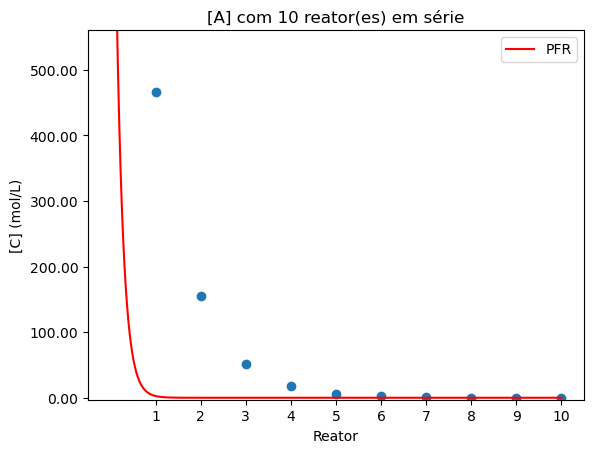

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.ticker import FormatStrFormatter

def rk4(f, Y0, time_window, args=None, h=1e-4):
    """
    Resolve um sistema de equações diferenciais ordinárias (EDOs) utilizando o método de Runge-Kutta de quarta ordem.

    Args:
        f: função que retorna a derivada da função Y em relação ao tempo. Deve receber dois argumentos: t e Y.
        Y0: lista ou array contendo as condições iniciais para as funções Y. Deve ter o mesmo comprimento que o número de equações em f.
        time_window: lista ou tupla contendo o tempo inicial (t0) e o final (tf).
        h: tamanho do passo.

    Returns:
        Uma tupla contendo dois arrays: o primeiro com o tempo (t) e o segundo com as soluções do sistema de EDOs para cada tempo (Y).
    """
    if args is not None:
        # Wrap the user's fun (and jac, if given) in lambdas to hide the
        # additional parameters.  Pass in the original fun as a keyword
        # argument to keep it in the scope of the lambda.
        try:
            _ = [*(args)]
        except TypeError as exp:
            suggestion_tuple = (
                "Supplied 'args' cannot be unpacked. Please supply `args`"
                f" as a tuple (e.g. `args=({args},)`)"
            )
            raise TypeError(suggestion_tuple) from exp

        f = lambda t, x, f=f: f(t, x, *args)
    # Calcula o número total de passos a serem dados
    t0, tf = time_window
    n = int((tf-t0)/h)

    # Cria arrays para armazenar os resultados
    t = np.zeros(n+1)
    Y = np.zeros((n+1, len(Y0)))
    Y[0] = Y0
    t[0] = t0
    
    # Aplica o método de Runge-Kutta de quarta ordem
    for i in range(n):
        k1 = np.array(f(t[i], Y[i]))
        k2 = np.array(f(t[i] + h/2, Y[i] + h*k1/2))
        k3 = np.array(f(t[i] + h/2, Y[i] + h*k2/2))
        k4 = np.array(f(t[i] + h, Y[i] + h*k3))
        Y[i+1] = Y[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        t[i+1] = t[i] + h
    # Retorna os resultados como uma tupla de arrays
    return t, Y

#cstr simples isotérmico A -> B
def cstr_v2(n_reatores, k, V, vaz, c_a0, tag=1, metodo=0, grafico=1):
    """
    Resolve o problema de um sistema de reatores contínuos em série, onde o reagente A é consumido em cada reator.

    Parâmetros:
    n_reatores (int): número de reatores na série.
    tag (int): se 0, os valores de entrada devem ser inseridos pelo usuário. Se 1, valores pré-definidos serão usados.
    metodo (int): método a ser usado para resolver o sistema de equações. Se 0, fsolve do scipy será usado. Se 1, a inversa da matriz A será usada.
    grafico (int): se 1, um gráfico dos resultados será plotado. Se 0, uma tupla com os resultados será retornada.

    Retorna:
    Se grafico=1, nenhum valor é retornado. Se grafico=0, uma tupla com dois elementos é retornada. O primeiro elemento é uma lista com o número dos reatores, o segundo é uma lista com as concentrações de A em cada reator.

    """
    if tag == 0:
        print("Digite os valores das vazões positivas para entrada e negativas para saída de cada reator!", "\n", 
          "Os vetores de vazão (Q_n) devem ser compostos em cada posição pela soma das vazões associadas a concentração", "\n",
          "do reagente A em cada tanque [c_a1, c_a2, ..., c_an], exemplo: o vetor vazão do tanque 1 é Q_1 =[-10, 0, ..., 0]")
        A=[]
        for i in range(1, n_reatores+1):
            Q=input("Insira Q_"+ str(i)+ " com as "+str(n_reatores)+" entradas do vetor separadas por espaço: ")
            A.append([int(vaz) for vaz in Q.split(' ')])
        k=[float(const) for const in input("Insira as constantes de reação separadas por espaço: ").split(' ')]
        V=[float(vol) for vol in input("Insira os volumes de cada um dos reatores separados por espaço: ").split(' ')] 
        entrada = int(input("Qual o valor da entrada multiplicada pela vazão? "))       
    else:
        A=np.zeros((n_reatores, n_reatores))
        for i in range(n_reatores):
            if i == 0:
                A[i][0] = -vaz
            else:
                A[i][i] = -vaz
                A[i][i-1] = vaz
        entrada = c_a0*vaz 
    start = time.time()     
    r = [-k[i]*V[i] for i in range(n_reatores)]
    for i in range(n_reatores):
        A[i][i] += r[i]
    b = np.transpose([[-entrada] + [0 for k in range(n_reatores-1)]])
    
    if metodo==0:
        def equa(x, *data):
            A_matrix, b_matrix = data
            guess = np.transpose([x])
            return np.transpose(np.matmul(A_matrix, guess) - b_matrix)[0]
        dados = (A, b)
        roots = fsolve(equa, [1 for i in range(n_reatores)], args=dados)
    else:
        roots = np.transpose(np.matmul(np.linalg.inv(A), b))[0]
    print("############################################################################", "\n", "n° reatores: ", n_reatores, "\n", "volume de cada CSTR: ", V[0], "m3")
    for i in range(n_reatores):
        print("C_a{0} = {1:.5f} mol/L".format(i+1, roots[i]))
        if i==(n_reatores-1):
            end = time.time()
            elapsed = end - start
            print(f"Elapsed time: {elapsed:.5f} seconds")
    if grafico==1:
        fig, ax = plt.subplots()
        ax.set_xlabel('Reator')
        plt.xticks(range(1, n_reatores+1))
        ax.set_ylim(-3, 1.2*round(roots[0], 0))
        ax.set_ylabel('[C] (mol/L)')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_title('[A] com '+str(n_reatores)+" reator(es) em série")
        plt.scatter(range(1, n_reatores+1), roots)
        if n_reatores == 10:
            x, y = PFR(k[0], 1, vaz, [0, 10], [c_a0])
            plt.plot(x, y, label="PFR", color="r")
            plt.legend()
        plt.show()
    else:
        return (range(1, n_reatores+1), roots)

# simula um PFR isolado com reação A-> B
def PFR(k, R, Q, L, c_a0):
    def edo_1(x, c_a, k=k, R=R, Q=Q):
        return [-(k*c_a*np.pi*R**2)/Q]
    sol = rk4(edo_1, c_a0, L)
    x, c_a = sol
    return [x, c_a]


# Executando a função
n_cstr=[1, 2, 4, 10]
v_total = 10
for n in n_cstr:
    k=[]
    V=[]
    for i in range(n):
        k.append(10)
        V.append(v_total/n)
    cstr_v2(n, k, V, 5, 1400)


Como pode ser visto nos gráficos acima, uma série infinita de CSTR em série tende ao comportamento de um PFR. Quanto mais CSTR em série menor é a concentração do reagente A no final do processo. 

c)

A modelagem feita parte do balanço geral E - S + G - C = A, como temos estado estacionério o acúmulo é zero. A variação de E - S em um delta x pode ser expressa por: -Q(dc_a/dx)delta_x; o termo reacional fica: -k c_a V, no final vamos ter uma EDO de primeira ordem como mostrado na linha 51.

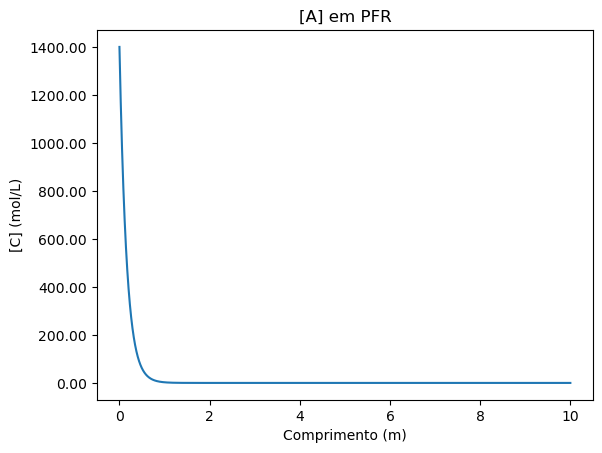

In [2]:
# simula um PFR isolado com reação A-> B
x, y = PFR(10, 1, 5, [0, 10], [1400])
fig, ax = plt.subplots()
ax.set_xlabel('Comprimento (m)')
ax.set_ylabel('[C] (mol/L)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("[A] em PFR")
plt.plot(x, y)
plt.show()


# Questão 2)

A questão foi resolvida com uma abordagem parecida com a realizada em exercícios propostos em aula, primeiro a EDO de segunda ordem foi reduzida a duas de primeira ordem que podem ser vistas em edo_2() então fez-se uso do fsolve() para encontrar o valor ideal para a condição inicial de w_0 que não é possível obter inicialmente, para isso buscamos zerar a edo_chute() já que ela garante que a condição de contorno do w no final da barra vai ser atendida. 

A modelagem que resultou no sistema de EDOs é uma simples análise de uma barra cilíndrica que sofre condução axial de calor sem perfil radial e que troca calor com o ambiente, logo o volume de controle é um cilindro com o raio da barra e altura Δx, através da Lei de Fick podemos modelar a difusão de calor e como a barra está em estado estacionário não há acúmulo.

Perda de Calor:  8.308959075055865 W - Cu
Perda de Calor:  5.5875519392957145 W - Al
Perda de Calor:  1.5582827049159318 W - Steel


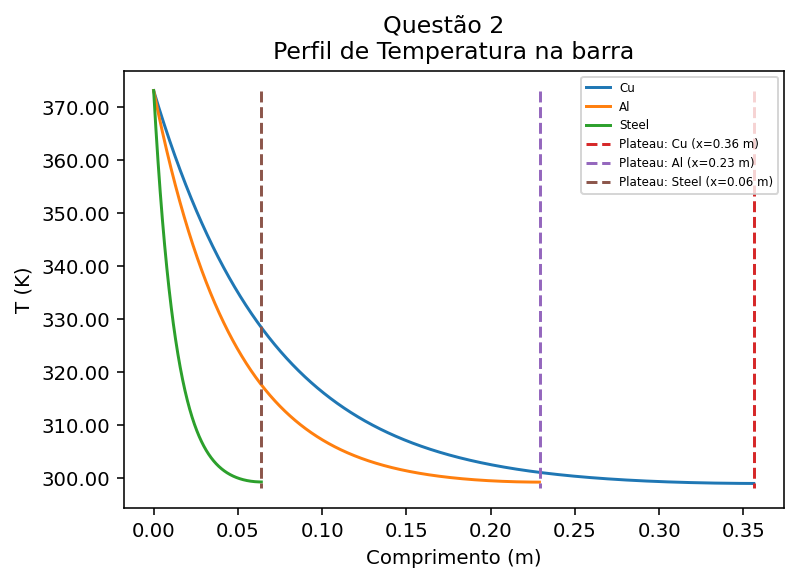

In [3]:
plt.close()
def edo_2(t, y, *dados):
    D_, T_w_, T_infi_, h_, k, L_ = dados
    R = D_/2
    T, w = y
    dTdx = w
    dwdx = -2*h_*(T_infi_-T)/(k*R)
    return [dTdx, dwdx]

def resolver_edo(w_0, dados):
    if type(w_0) == np.ndarray:
        chute = w_0[0]
    else:
        chute = w_0
    condicoes_iniciais = [T_w, chute]
    sol = rk4(edo_2, condicoes_iniciais, dados[-1], args=dados)
    y = np.transpose(sol[1])
    x, (T, w) = sol[0], y
    return x, (T, w)

def edo_chute(w_0, dados):
    x, (T, w) = resolver_edo(w_0=w_0, dados=dados)
    eq = w[-1]-(h/dados[3])*(T_infi-T[-1])
    return [eq]

def curva(dados):
    w_0 = fsolve(edo_chute, [1], args=dados)[0]
    x, (T, w) = resolver_edo(w_0, dados=dados)
    return x, T, w, w_0

dados = [5e-3, 100+273.15, 25+273.15, 100, 398, 180, 14]
D, T_w, T_infi, h, k_Cu, k_Al, k_steel = dados
L = [0, 4e-1]
lista_k = np.array([k_Cu, k_Al, k_steel])

fig, ax = plt.subplots()
plt.rcParams["figure.autolayout"] = True
ax.set_xlabel('Comprimento (m)')
ax.set_ylabel('T (K)')
fig.suptitle('Questão 2', fontsize=12)
fig.set_figwidth(6)
fig.set_figheight(4)
fig.set_dpi(142)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Perfil de Temperatura na barra")

# procurando Plateau
materiais = ["Cu", "Al", "Steel"]
plateau = []
for k_material in lista_k:
    x, y, w, w_0 = curva([D, T_w, T_infi, h, k_material, L])
    for temp in y:
        if abs(1.002*T_infi-temp) <= 5e-3:
            comprimento = x[np.where(y==temp)[0][0]]
            plateau.append([comprimento, temp])
            # encontrar a perda de calor: q = -k A dT/dx
            x, y, w, w_0_final = curva([D, T_w, T_infi, h, k_material, [0, comprimento]])
            print("Perda de Calor: ", -k_material*np.pi*((D/2)**2)*w_0_final, "W -", f"{materiais[np.where(lista_k==k_material)[0][0]]}")
            break
    plt.plot(x, y, label=materiais[np.where(lista_k == k_material)[0][0]])
for i in range(3):
    plt.plot(plateau[i][0]*np.ones(2), [T_w, T_infi], "--", label=f"Plateau: {materiais[i]} (x={round(plateau[i][0], 2)} m)")
plt.legend(loc="upper right", fontsize="6")
plt.show()


Os plateaus são encontrados a partir do loop da linha 49 que passa por todos os valores armazenados no vetor de temperatura obtido como resposta para resolução dos sistemas de EDOs de cada material e compara com um valor 0,2 % maior que a temperatura ambiente, quando esse valor é atingido (com uma certa tolerância) os dados de posição são armazenados, o sistema roda novamente o rk4 com o novo intervalo, posteriormente os resultados são plotados em um gráfico. A perda de calor é definida a partir do princípio de conservação de energia, inerentemente, tudo que entrou na barra por condução em x = 0 vai ser o que irá irradiar para o ambiente por todo comprimento da barra até o marco do plateau, logo a perda de calor da barra pode ser definida por q = -k_material * A_transversal * (dT/dx)_x=0, essa derivada no ponto x=0 é justamente o w_0, esse cálculo é feito na linha 57 e 58.

# Questão 3)

A questão 3 tem uma abordagem bem similar com a anterior. O perfil no anel de alumínio foi espelhado e rotacionado para melhorar a visualização.

w_0:  -241.9780663009757


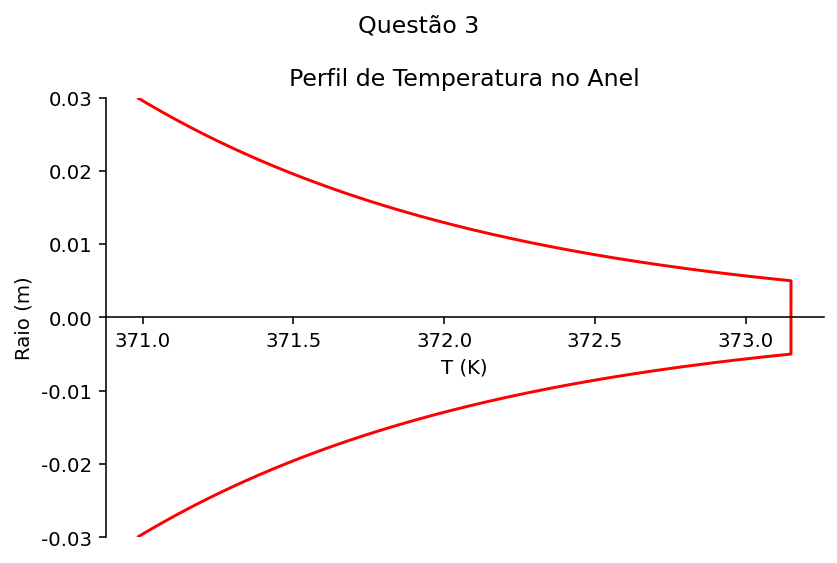

In [4]:
def edo_3(t, y, *dados):
    R1_, R2_, T0_, T_env_, k_Cu_, h_ = dados
    r = t
    T, w = y
    dTdr = w
    dwdr = -w/r
    return [dTdr, dwdr]

def resolver_edo(w_0, dados):
    if type(w_0) == np.ndarray:
        chute = w_0[0]
    else:
        chute = w_0
    condicoes_iniciais = [T0, chute]
    sol = rk4(edo_3, condicoes_iniciais, [dados[0], dados[1]], args=dados)
    y = np.transpose(sol[1])
    x, (T, w) = sol[0], y
    return x, (T, w)

def edo_chute(w_0, dados):
    x, (T, w) = resolver_edo(w_0=w_0, dados=dados)
    eq = w[-1]+(dados[-1]/dados[-2])*(T[-1]-T_env)
    return [eq]

def curva(dados):
    w_0 = fsolve(edo_chute, [1], args=dados)[0]
    x, (T, w) = resolver_edo(w_0, dados=dados)
    return x, T, w_0

dados = [0.5e-2, 3e-2, 100+273.15, 25+273.15, 180, 100]
R1, R2, T0, T_env, k_Cu, h = dados


fig, ax = plt.subplots()
plt.rcParams["figure.autolayout"] = True
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlabel('T (K)')
ax.set_ylim(-R2, R2)
ax.set_ylabel('Raio (m)')
fig.suptitle('Questão 3', fontsize=12)
fig.set_figwidth(6)
fig.set_figheight(4)
fig.set_dpi(142)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Perfil de Temperatura no Anel")
x, y, w_0 = curva(dados)
print("w_0: ", w_0)
plt.plot(np.concatenate((y[::-1],y), axis=None), np.concatenate((x[::-1], -x), axis=None), color="r")
plt.show()

# 4)

Como o problema exige que usemos um passo pequeno no rk4 para que o resultado seja satisfatório, dado a rigidez do sistema, a matriz de solução das 8 EDOs acaba sendo grande e pose ser bem pesada, o código foi otimizado para rodar em aproximadamente 2:20 min mas para facilitar a manipulação dos dados posteriormente o resultado da rk4 foi armazenado em um txt.
Primeiro resolvi as EDOs até 20 000 segundos e com os dados comecei o tratamento de acordo com o que a questão solicitava.

In [7]:
# definindo as EDOs
def edo_4(t, y, *dados):
    f_, kd_, kp_, ktd_, ktc_, Ci0_, Cm0_ = dados
    Y0, Y1, Y2, Q0, Q1, Q2, Ci, Cm = y
    # derivadas no tempo
    dY0 = 2*f_*kd_*Ci -(ktc_+ktd_)*Y0**2
    dY1 = kp_*Cm*Y0 -(ktc_+ktd_)*Y0*Y1
    dY2 = kp_*Cm*Y0 +2*kp_*Cm*Y1 -(ktc_+ktd_)*Y0*Y2
    dQ0 = (ktd_+ktc_/2)*Y0**2
    dQ1 = (ktc_+ktd_)*Y0*Y1
    dQ2 = (ktc_+ktd_)*Y0*Y2 + ktc_*Y1**2
    dCi = -kd_*Ci
    dCm = -kp_*Cm*Y0
    return [dY0, dY1, dY2, dQ0, dQ1, dQ2, dCi, dCm]

# setup do problema
dados = [6e-1, 1e-5, 1.6e3, 1e8, 1e8, 1e-1, 5.0]
# intervalo de tempo global
intervalo_tempo_global = [0, 2e4]
passo = 1e-2

# resolvendo o sistema das 8 EDOs
time, concentrações = rk4(edo_4, [0, 0, 0, 0, 0, 0, dados[-2], dados[-1]], intervalo_tempo_global, args=dados, h=passo)

# guardando os dados gerados em um dataframe para tratálos posteriormente
df = pd.DataFrame(concentrações, index=time, columns=["Y0", "Y1", "Y2", "Q0", "Q1", "Q2", "Ci", "Cm"])
df.to_csv("output4_RK4.txt")


In [8]:
# abrindo o dataframe para np array
data = pd.read_csv("output4_RK4.txt")
data_vect = np.array(data.values.tolist())


Valores finais: 
 Conversão: 58.375 % 
 Massa Molar Média: 23341.47 g/mol 
 Massa Molar Ponderal: 46354.121 g/mol 
 Dispersividade: 1.986


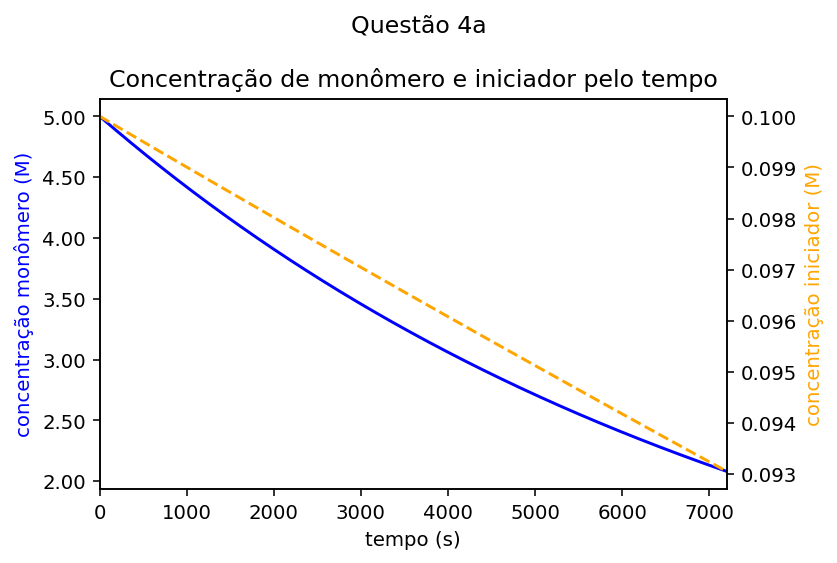

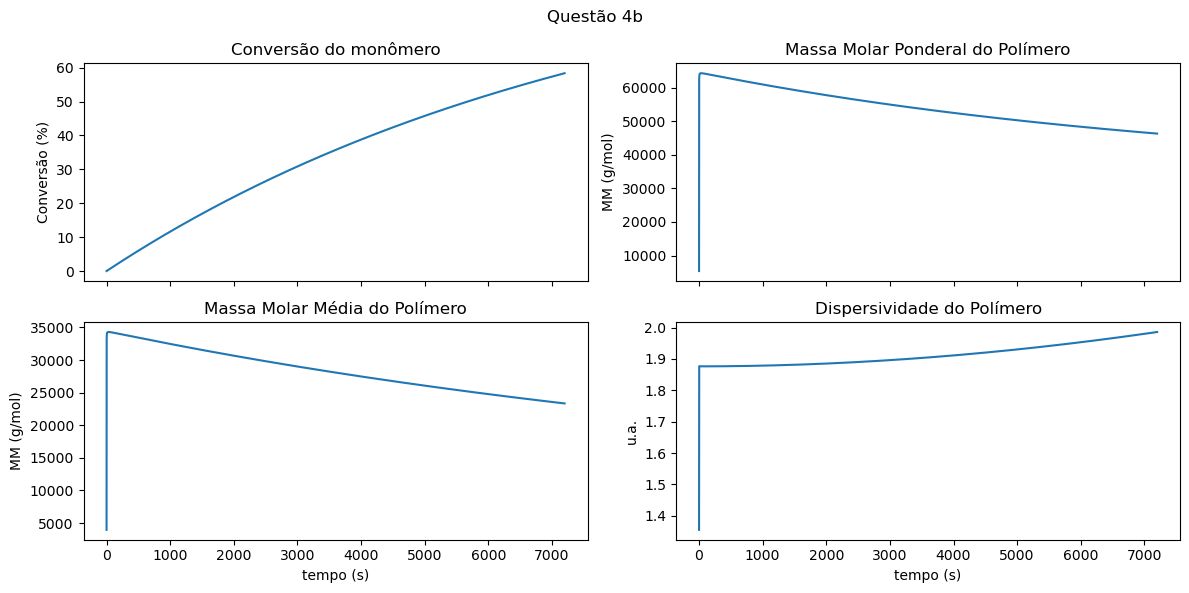

In [9]:
# análise de dados 2 h
intervalo_tempo = [0, 7200]
ti, tf = intervalo_tempo
n_pontos = int((tf-ti)*(passo**-1)+1)
head_start = int((ti)*(passo**-1))
data_2h = data_vect[head_start:n_pontos]
data_2h = data_2h.transpose()
t, y0, y1, y2, q0, q1, q2, ci, cm = data_2h

#plotando figuras
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)
plt.rcParams["figure.autolayout"] = True
ax.set_xlabel('tempo (s)')
ax.set_xlim(intervalo_tempo)
ax.set_ylabel('concentração monômero (M)', color="blue")
ax2.set_ylabel('concentração iniciador (M)', color="orange")
fig.suptitle('Questão 4a', fontsize=12)
fig.set_figwidth(6)
fig.set_figheight(4)
fig.set_dpi(142)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Concentração de monômero e iniciador pelo tempo")
ax2.plot(t, ci, "--", label="iniciador", color="orange")
ax.plot(t, cm, label="monômero", color="blue")
# plt.close()

# análise de dados
fig2, axs = plt.subplots(2, 2, sharex=True,)
fig2.suptitle('Questão 4b', fontsize=12)
fig2.set_figwidth(12)
fig2.set_figheight(6)
# conversão
conversão = [100*(dados[-1] - cm[i])/dados[-1] for i in range(2, n_pontos)]
axs[0, 0].plot(t[1:-1], conversão)
axs[0, 0].set_ylabel('Conversão (%)')
axs[0, 0].set_title("Conversão do monômero")

# massa molar média
MM = 50
MM_medio = [MM*((q1[i]+y1[i])/(q0[i]+y0[i])) for i in range(2, n_pontos)]
axs[1, 0].plot(t[1:-1], MM_medio)
axs[1, 0].set_ylabel('MM (g/mol)')
axs[1, 0].set_title("Massa Molar Média do Polímero")
axs[1, 0].set_xlabel('tempo (s)')
# massa molar ponderal
MM_ponderal = [MM*((q2[i] +y2[i])/(q1[i]+y1[i])) for i in range(2, n_pontos)]
axs[0, 1].plot(t[1:-1], MM_ponderal)
axs[0, 1].set_ylabel('MM (g/mol)')
axs[0, 1].set_title("Massa Molar Ponderal do Polímero")

# Dispersividade
Disper = [MM_ponderal[i]/MM_medio[i] for i in range(n_pontos-2)]
axs[1, 1].plot(t[1:-1], Disper)
axs[1, 1].set_ylabel('u.a.')
axs[1, 1].set_xlabel('tempo (s)')
axs[1, 1].set_title("Dispersividade do Polímero")
print("Valores finais:", "\n", f"Conversão: {round(conversão[-1], 3)} %", "\n", \
    f"Massa Molar Média: {round(MM_medio[-1], 3)} g/mol", "\n", f"Massa Molar Ponderal: {round(MM_ponderal[-1], 3)} g/mol", \
    "\n", f"Dispersividade: {round(Disper[-1], 3)}")
plt.show()


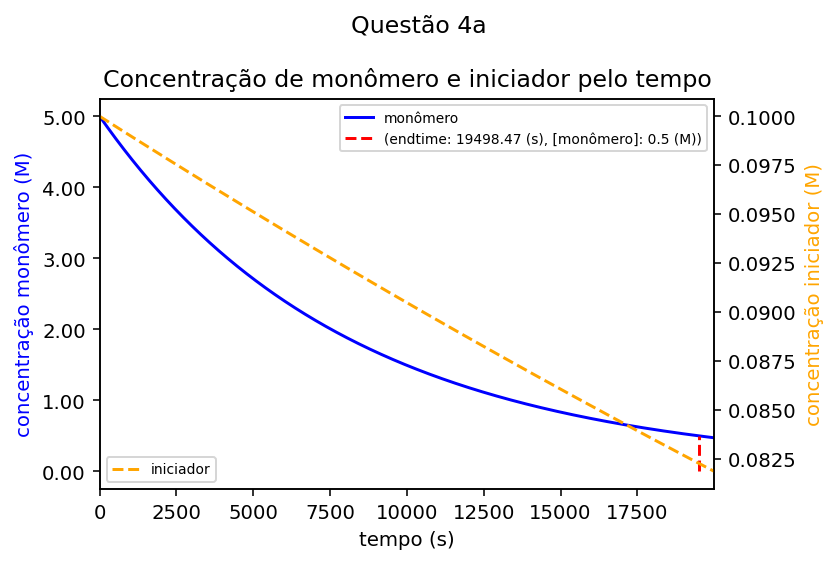

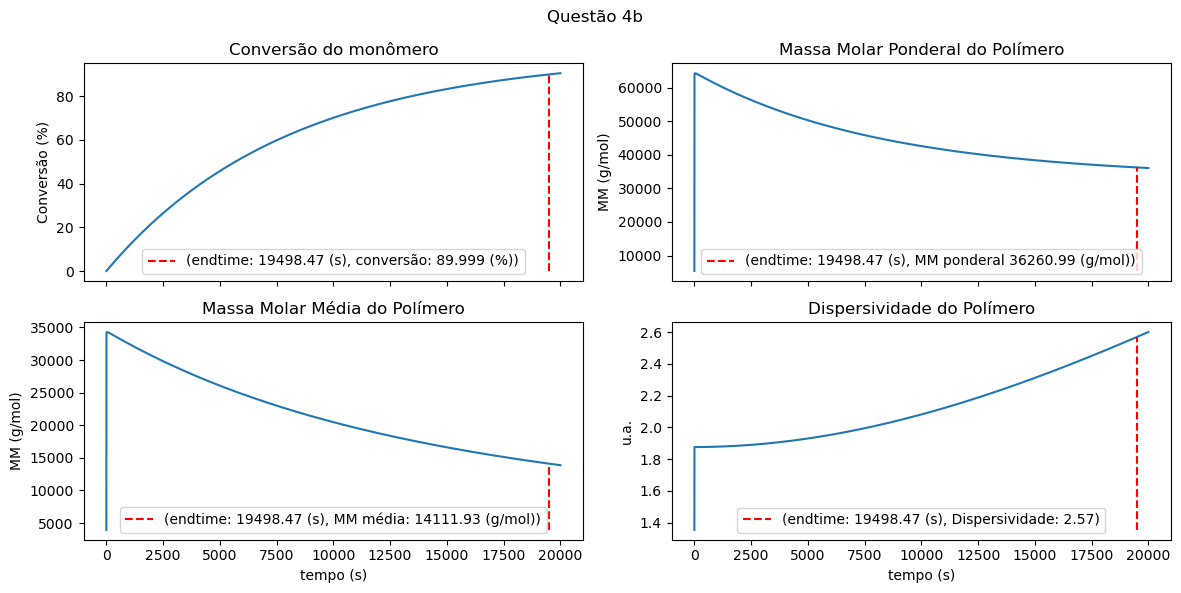

In [10]:
# análise de dados 90 % de conversão
plt.close()
intervalo_tempo = [0, 19999]
ti, tf = intervalo_tempo
n_pontos = int((tf-ti)*(passo**-1)+1)
head_start = int((ti)*(passo**-1))
data_5h = data_vect[head_start:n_pontos]
data_5h = data_5h.transpose()
t, y0, y1, y2, q0, q1, q2, ci, cm = data_5h

conversão_desejada = 90
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)
plt.rcParams["figure.autolayout"] = True
ax.set_xlabel('tempo (s)')
ax.set_xlim(intervalo_tempo)
ax.set_ylabel('concentração monômero (M)', color="blue")
ax2.set_ylabel('concentração iniciador (M)', color="orange")
fig.suptitle('Questão 4a', fontsize=12)
fig.set_figwidth(6)
fig.set_figheight(4)
fig.set_dpi(142)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Concentração de monômero e iniciador pelo tempo")
ax2.plot(t, ci, "--", label="iniciador", color="orange")
ax.plot(t, cm, label="monômero", color="blue")
# plt.close()

# análise de dados
fig2, axs = plt.subplots(2, 2, sharex=True,)
fig2.suptitle('Questão 4b', fontsize=12)
fig2.set_figwidth(12)
fig2.set_figheight(6)
# conversão
conversão = np.array([100*(dados[-1] - cm[i])/dados[-1] for i in range(2, n_pontos)])
# revert = np.flip(conversão)
for porcent in conversão:
    if abs(conversão_desejada - porcent) <= 1e-3:
        time_stamp_90 = np.where(conversão == porcent)[0][0] + 2
        ideal = [t[time_stamp_90], porcent]
        end_time = ideal[0]
        break
axs[0, 0].plot(t[1:-1], conversão)
axs[0, 0].plot(end_time*np.ones(2), [conversão[0], ideal[1]], "--", label=f"(endtime: {round(end_time, 2)} (s), conversão: {round(ideal[1], 3)} (%))", color="r")
axs[0, 0].legend(loc="lower center")
axs[0, 0].set_ylabel('Conversão (%)')
axs[0, 0].set_title("Conversão do monômero")

# massa molar média
MM = 50
MM_medio = [MM*((q1[i]+y1[i])/(q0[i]+y0[i])) for i in range(2, n_pontos)]
axs[1, 0].plot(t[1:-1], MM_medio)
# 90%
axs[1, 0].plot(end_time*np.ones(2), [MM_medio[0], MM_medio[time_stamp_90]], "--", label=f"(endtime: {round(end_time, 2)} (s), MM média: {round(MM_medio[time_stamp_90],2)} (g/mol))", color="r")
axs[1, 0].legend(loc="lower center")
axs[1, 0].set_ylabel('MM (g/mol)')
axs[1, 0].set_title("Massa Molar Média do Polímero")
axs[1, 0].set_xlabel('tempo (s)')
# massa molar ponderal
MM_ponderal = [MM*((q2[i] +y2[i])/(q1[i]+y1[i])) for i in range(2, n_pontos)]
axs[0, 1].plot(t[1:-1], MM_ponderal)
# 90%
axs[0, 1].plot(end_time*np.ones(2), [MM_ponderal[0], MM_ponderal[time_stamp_90]], "--", label=f"(endtime: {round(end_time, 2)} (s), MM ponderal {round(MM_ponderal[time_stamp_90],2)} (g/mol))", color="r")
axs[0, 1].legend(loc="lower center")
axs[0, 1].set_ylabel('MM (g/mol)')
axs[0, 1].set_title("Massa Molar Ponderal do Polímero")

# Dispersividade
Disper = [MM_ponderal[i]/MM_medio[i] for i in range(n_pontos-2)]
axs[1, 1].plot(t[1:-1], Disper)
# 90%
axs[1, 1].plot(end_time*np.ones(2), [Disper[0], Disper[time_stamp_90]], "--", label=f"(endtime: {round(end_time, 2)} (s), Dispersividade: {round(Disper[time_stamp_90],2)})", color="r")
axs[1, 1].legend(loc="lower center")
axs[1, 1].set_ylabel('u.a.')
axs[1, 1].set_xlabel('tempo (s)')
axs[1, 1].set_title("Dispersividade do Polímero")

# 90%
ax.plot(end_time*np.ones(2), [0, cm[time_stamp_90]], "--", label=f"(endtime: {round(end_time, 2)} (s), [monômero]: {round(cm[time_stamp_90], 2)} (M))", color="r")
ax.legend(fontsize="7")
ax2.legend(fontsize="7", loc="lower left")
plt.show()


In [11]:
from scipy.integrate import solve_ivp

# solucionando o sistema já definido através agora do solve_ivp() Radau
passo_ivp = 1
intervalo_ivp = [0, 3600]
sol = solve_ivp(edo_4, intervalo_ivp, [0, 0, 0, 0, 0, 0, 0.1, 5], args=[6e-1, 1e-5, 1.6e3, 1e8, 1e8, 1e-1, 5.0], method="Radau")

# guardando os dados gerados em um dataframe para tratá-los posteriormente
df = pd.DataFrame(np.transpose(sol.y), index=sol.t, columns=["Y0", "Y1", "Y2", "Q0", "Q1", "Q2", "Ci", "Cm"])
df.to_csv("output4_ivp_implicito_spasso.txt")
# abrindo o dataframe para np array
data_ivp = pd.read_csv("output4_ivp_implicito_spasso.txt")
data_vect_ivp_radau = np.array(data_ivp.values.tolist())


In [12]:
# solucionando o sistema já definido através agora do solve_ivp() RK45
sol = solve_ivp(edo_4, intervalo_ivp, [0, 0, 0, 0, 0, 0, 0.1, 5], args=dados)

# guardando os dados gerados em um dataframe para tratá-los posteriormente
df = pd.DataFrame(np.transpose(sol.y), index=sol.t, columns=["Y0", "Y1", "Y2", "Q0", "Q1", "Q2", "Ci", "Cm"])
df.to_csv("output4_ivp_explicito_spasso.txt")
# abrindo o dataframe para np array
data_ivp = pd.read_csv("output4_ivp_explicito_spasso.txt")
data_vect_ivp_expl = np.array(data_ivp.values.tolist())

Radau precisou de 19 passos
RK45 Explícito precisou de 33580 passos


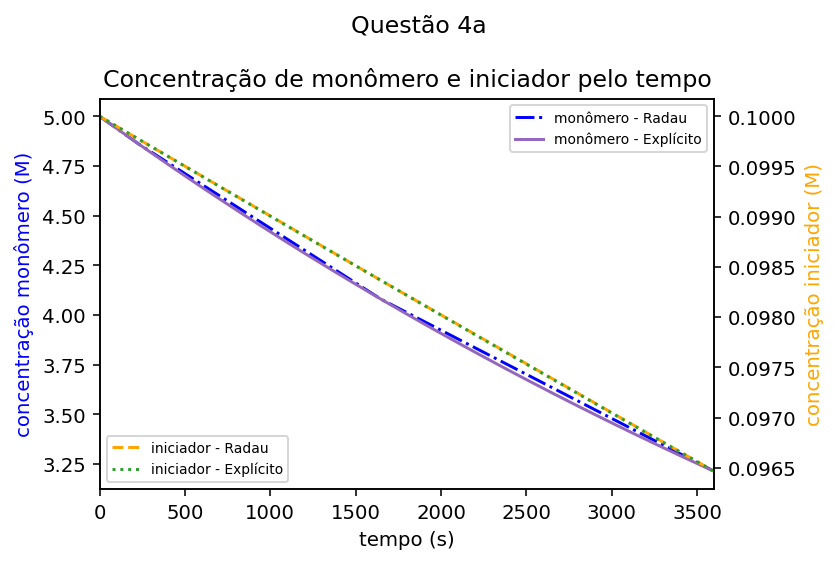

In [13]:
#análise de dados pelo ivp Radau
plt.close()
intervalo_tempo = intervalo_ivp
ti, tf = intervalo_tempo
data_ivp_1h_radau = data_vect_ivp_radau
data_ivp_1h_radau = data_ivp_1h_radau.transpose()
t_R, y0_R, y1_R, y2_R, q0_R, q1_R, q2_R, ci, cm = data_ivp_1h_radau
n_pontos = len(cm)
print(f"Radau precisou de {n_pontos} passos")
#pltando Radau
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)
plt.rcParams["figure.autolayout"] = True
ax.set_xlabel('tempo (s)')
ax.set_xlim(intervalo_tempo)
ax.set_ylabel('concentração monômero (M)', color="blue")
ax2.set_ylabel('concentração iniciador (M)', color="orange")
fig.suptitle('Questão 4a', fontsize=12)
fig.set_figwidth(6)
fig.set_figheight(4)
fig.set_dpi(142)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Concentração de monômero e iniciador pelo tempo")
ax2.plot(t_R, ci, "--", label="iniciador - Radau", color="orange")
ax.plot(t_R, cm, "-.", label="monômero - Radau", color="blue")
ax.legend(fontsize="7")
ax2.legend(fontsize="7", loc="lower left")

#análise de dados ivp Explícito
data_ivp_1h_expl = data_vect_ivp_expl
data_ivp_1h_expl = data_ivp_1h_expl.transpose()
t, y0, y1, y2, q0, q1, q2, ci, cm = data_ivp_1h_expl
n_pontos = len(cm)
print(f"RK45 Explícito precisou de {n_pontos} passos")
#pltando Expl
ax2.plot(t, ci, ":", label="iniciador - Explícito", color="tab:green")
ax.plot(t, cm, label="monômero - Explícito", color="tab:purple")
ax.legend(fontsize="7")
ax2.legend(fontsize="7", loc="lower left")
plt.show()


A diferença na quantidade de passos é devido a característica do sistema de EDOs. O sistema montado é rígido e pela variação aguda nos momentos, o Radau lida melhor com esse tipo de variação e por isso para convergir precisa de menos passos que o RK45.
Os perfis são próximos mas devido a quantidade maior de pontos no RK45 ele se aproxima mais da solução real com melhor resolução.